<a href="https://colab.research.google.com/github/50-Course/swarm-optimizers/blob/main/SwarmOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Function to perform random search starting from a given point
def random_search(f, initial_point, max_evals, constraint_functions=None):
    best_x = initial_point
    best_f = f(initial_point)

    for _ in range(max_evals):
        # Generate a random point in the feasible region
        random_point = np.random.uniform(low=1, high=16, size=len(initial_point))

        # Check constraints if provided
        if constraint_functions:
            constraints_satisfied = all(c['fun'](random_point) <= 0 for c in constraint_functions)
        else:
            constraints_satisfied = True

        if constraints_satisfied:
            # Evaluate the objective function at the random point
            random_f = f(random_point)

            # Update the best solution if the new one is better
            if random_f > best_f:
                best_f = random_f
                best_x = random_point

    return best_x, best_f

# Example usage:
result_from_optimization = optimized_result.x
max_evaluations = 1000  # Adjust as needed

best_random_x, best_random_f = random_search(f, result_from_optimization, max_evaluations, constraint_functions)
print(f'Type of point: {type(result_from_optimization)}')
print(f'Random search global maxima: {best_random_f}')
print(f'Random search optimal objective value: {best_random_x}')

In [5]:
# DEPENDENCIES
import numpy as np
import scipy
import matplotlib.pyplot as plt

from fractions import Fraction
import math

In [6]:
# Utilities functions that just help me debug, right


# Takes in a constraint function and let's me inspect its value
def print_constraint_values(constraint_function):
    def wrapper(x):
        value = constraint_function(x)
        print(f"{constraint_function.__name__}:", value)
        return value
    return wrapper

# Evaluate function calls
def count_calls(counter_map):
  def decorator(func):
      def wrapper(*args, **kwargs):
          # Get the name of the decorated function
          func_name = func.__name__

          # Increment the counter for the function
          counter_map[func_name] += 1

          # Call the original function
          result = func(*args, **kwargs)

          return result

      return wrapper

  return decorator

In [7]:
# FUNCTION IMPLEMENTATIONS

# Global counter
FN_COUNTER_MAP = {
  'f': 0,
  'g1': 0,
  'g2': 0,
  'g3': 0,
  'g4': 0,
  'g5': 0,
  'g6': 0,
  'g7': 0
}



def P(x):
  return (np.log10(np.log10(8.122 * x[3] + 0.8)) - 10.04) / -3.55


def W(x):
  """Calculates the load carrying capacity.

  Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid



  Returns:
    The load carrying capacity.
  """

  return (np.pi * P0(x) / 2) * (x * (2/3) - x * (2/2) / np.log(x[2] / x[1]))


def P0(x):
  """Calculates the inlet pressure.

 Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid

  Returns:
    The inlet pressure.
  """
  return ((6e-6 * x[3] * x[0]) / (np.pi * h(x)**3)) * np.log(x[2] / x[1])


def Ef(x):
  """Calculates the friction loss.

Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid

  Returns:
    The friction loss.
  """
  return 143.308 * delta_t(x) * x[0]

def delta_t(x):
  return 2 * (np.power(10, P(x)) - 560)


def f(x):
  """Computes the operational power loss of a cylindrical hydrostatic thrust bearing.

  Args:
    x: A decision vector containing the flow rate, recess radius, bearing step radius, and fluid viscosity.

  Returns:
    The operational power loss.
  """

  return np.mean((P0(x) * x[0]) / 0.7 + Ef(x))

#def minf(X, constraint_functions=None):
#  """
#  Computes the local minima of f(x) for x in X
#  """
#  return scipy.optimize.minimize((f(x) for x in X), X, bounds=(1, 16), constraints=constraint_functions)

def minf(X, constraint_functions=None):
    """
    Computes the local minima of f(x) for x in X
    """
    LOWER_BOUND = 1.0
    UPPER_BOUND = 16.0
    bounds = [(LOWER_BOUND, UPPER_BOUND),
            (LOWER_BOUND, UPPER_BOUND),
            (LOWER_BOUND, UPPER_BOUND),
            (LOWER_BOUND, UPPER_BOUND)]
    return scipy.optimize.minimize(f, X, method='L-BFGS-B', bounds=bounds, constraints=constraint_functions)

def h(x):
  """Calculates the oil thickness.

  Args:
    decision vector x=(Q,Ro,Rs,μ), where x==[x0,x1,x2,x3],:

      Q; is the flow rate
      Ro: is the recess radius
      Rs: is the bearing step radius
      μ: is the viscosity of the fluid

  Returns:
    The oil thickness.
  """
  return (1500 * np.pi / 60)**2 * (2e-6 * np.pi * x[3] / Ef(x)) * (x*Fraction(4, 3) / 4) - (x*Fraction(4, 2) / 4)


@count_calls(FN_COUNTER_MAP)
def g1(x):
  """Calculates the first constraint function."""
  return np.mean(W(x)) - 101000


@count_calls(FN_COUNTER_MAP)
def g2(x):
  """Calculates the second constraint function."""
  return np.mean(P0(x)) - 1000

@count_calls(FN_COUNTER_MAP)
def g3(x):
  """Calculates the third constraint function."""
  return np.mean(delta_t(x))

@count_calls(FN_COUNTER_MAP)
def g4(x):
  """Calculates the fourth constraint function."""
  return np.mean(h(x)) - 0.001


@count_calls(FN_COUNTER_MAP)
def g5(x):
  """Calculates the fifth constraint function."""
  return x[2] - x[1]

@count_calls(FN_COUNTER_MAP)
def g6(x):
  """Calculates the sixth constraint function."""
  numerator = 0.0307 * x[0]
  denominator = 772.8 * np.pi * P0(x) * h(x) * x[2]
  return np.mean(( numerator / denominator)) - 0.001

@count_calls(FN_COUNTER_MAP)
def g7(x):
  """Calculates the seventh constraint function."""
  return np.mean(W(x) / np.pi * (x*Fraction(2, 3) - x*Fraction(2, 2)) - 5000)

In [57]:
# RANDOM SEARCH IMPLEMENTATION
def random_search(
    f,
    decision_vector: np.ndarray,
    seed: int = 2023,
    low: int | float = 1.0,
    high: int | float = 16,
    max_evals: int = 10_000,
    constraint_functions: list = None):
    """
    Ranomly explores the search space (in our case, the decision vector,
    which is a function result of our minimization algorithm).

    f: objective function to be optimized
    seed: random seed for reproducibility
    lb: lower bound of our search space
    ub: upper bound of our search space
    max_evals: maximum number of evaluations
    """

    np.random.seed(seed)
    best_x = decision_vector
    best_f = f(decision_vector)

    evals = 0 # number of evaluations

    # loop until max_evals
    while evals < max_evals:
        # Generate a random point in the feasible region
        x = np.random.uniform(low=1, high=16, size=len(decision_vector))

        x = np.clip(x, low, high)

        # check if constraint is satisfied
        if constraint_functions:
            constraints_satisfied = all(c['fun'](decision_vector) <= 0 for c in constraint_functions)
        else:
            constraints_satisfied = True

        if constraints_satisfied:
          # Evaluate the objective function at the random point
          fx = f(x)

          # Update the best solution if the new one is better
          if fx < best_f:
              best_x = x
              best_f = fx

          # We just encountered a successful point, step over to next iteration
          evals += 1

    return best_x, best_f


In [58]:
# VALIDATION CODE

x = np.array([4.19, 11.57, 6.69, 10.65])

#sp.optimize.fmin(f, x)
#sp.optimize.minimize(f, x)

print("Objective function output, f(x) = ", f(x))
print("Constraint function output, g1(x) = ", g1(x))
print("Constraint function output, g2(x) = ", g2(x))
print("Constraint function output, g3(x) = ", g3(x))
print("Constraint function output, g4(x) = ", g4(x))
print("Constraint function output, g5(x) = ", g5(x))
print("Constraint function output, g6(x) = ", g6(x))
print("Constraint function output, g7(x) = ", g7(x))

constraint_functions = [
    {'type': 'ineq', 'fun': g1},
    {'type': 'ineq', 'fun': g2},
    {'type': 'ineq', 'fun': g3},
    {'type': 'ineq', 'fun': g4},
    {'type': 'ineq', 'fun': g5},
    {'type': 'ineq', 'fun': g6},
    {'type': 'ineq', 'fun': g7}
]

optimized_result = minf(x, constraint_functions)
print(f'Constraining: {optimized_result}')

Objective function output, f(x) =  -1784.0769823121077
Constraint function output, g1(x) =  -100999.99996507593
Constraint function output, g2(x) =  -999.9999982820297
Constraint function output, g3(x) =  -2.971181173735431
Constraint function output, g4(x) =  -4.139138178830784
Constraint function output, g5(x) =  -4.88
Constraint function output, g6(x) =  -3.2844870511943767
Constraint function output, g7(x) =  -5000.000022036623
Constraining:   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -68488.33657677178
        x: [ 1.600e+01  1.157e+01  6.690e+00  1.600e+01]
      nit: 1
      jac: [-4.281e+03  0.000e+00  0.000e+00 -8.975e+03]
     nfev: 10
     njev: 2
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


In [59]:
def simulated_annealing(
    f,
    initial_solution: np.ndarray,
    seed: int = 2023,
    constraint_functions: list = None,
    max_evaluations: int = 10_000,
    temperature_schedule = lambda t: max(0.01, 0.9**t)): # Entropy temperature, between 0 and 1
    """
    initial_solution: point in the randomized solution from our decision vector,
                      of which we intend to explore its global maxima

                      (Solution to be evaluated here comes from the random search)

    f: objective function to be optimized
    tenperature_schedule: function that takes the current iteration and returns the temperature
    max_evaluations: maximum number of evaluations
    """

    np.random.seed(seed)    # Set the random seed for reproducibility

    # Set our best point, to our starting point
    current_point = initial_solution
    best_point = current_point

    evaluations = 0

    while evaluations < max_evaluations:
        temperature = temperature_schedule(evaluations / max_evaluations)

        # Generate a neighboring solution, essential a random point in our decision space
        neighbor_point = current_point + np.random.uniform(1.0, 16.0, size=len(initial_solution))
        # neighbor_value = f(neighbor_solution)

        if constraint_functions:
            constraints_satisfied = all(c['fun'](neighbor_point) <= 0 for c in constraint_functions)
        else:
            constraints_satisfied = True

        if constraints_satisfied:
            # Evaluate the objective function at the neighbor point
            current_energy = f(current_point)
            neighbor_energy = f(neighbor_point)

            # Accept the neighbor if it's better or with a certain probability
            if neighbor_energy > current_energy or np.random.rand() < np.exp(np.nanmin(current_energy - neighbor_energy) / temperature):
                current_point = neighbor_point

                # Update the best solution if the current solution is better
                if neighbor_energy > f(best_point):
                    best_point = neighbor_point

        # Perform next evaluation
        evaluations += 1

    return best_point, f(best_point)

In [ ]:
# Perform random search and simulated annealing simulations, 21 times
random_search_results = [random_search(f, optimized_result.x, seed=21, constraint_functions=constraint_functions) for _ in range(21)]
SA_results = [simulated_annealing(f, optimized_result.x, seed=11, constraint_functions=constraint_functions) for _ in range(21)]


In [109]:
print(f'Random Search Result: {random_search_results}')
print(f'SA Result: {SA_results}')
print(f'Shape of Results: {np.array(random_search_results, dtype=object).shape}, {np.array(SA_results, dtype=object).shape}')

Random Search Result: [(array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16.  ]), -68488.33657677178), (array([16.  , 11.57,  6.69, 16. 

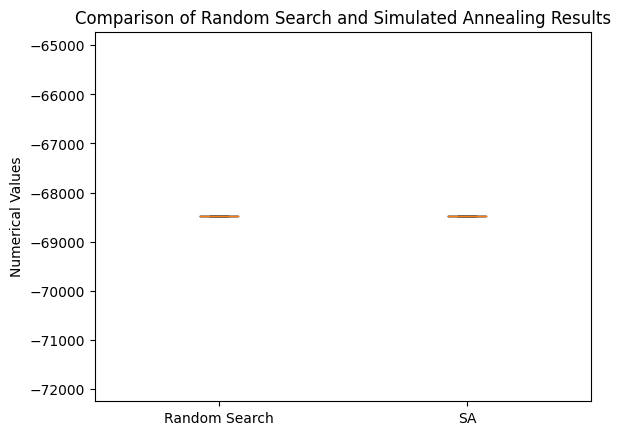

In [110]:
# GRAPH PLOTTING

def plot_graph(search_results, sim_results) -> None:
  """
  A box plot showing performances of the competing optimisers
  (the random search and the SA method) over 21 repetitions.

  Essentially, the box plot shows the distribution of the best objective
  function values found by each optimiser.
  """

  rs_results = [(array, value) for array, value in search_results]
  sa_results = [(array, value) for array, value in sim_results]

  # Extract the numerical values from the results
  random_search_values = [rs_result[1] for rs_result in rs_results]
  sa_values = [sa_result[1] for sa_result in sa_results]


  # Create a box plot
  plt.boxplot([random_search_values, sa_values], labels=['Random Search', 'SA'])
  plt.title('Performance Comparison of Random Search and Simulated Annealing Results')
  plt.ylabel('Numerical Values')
  plt.show()

plot_graph(search_results=random_search_results, sim_results=SA_results)

**Notes on the Algorithm Comparision over 21 simulations**

---

The provided data for both Random Search and Simulated Annealing shows identical results across all 21 repetitions. The box plot comparison may not reveal significant performance differences based on the current  dataset.

Should our search space involve, significant change, the distribution space over which our algorithm performs would change, effectively, resulting to a different 'visible' change performance of both algorithms.